In [1]:
import os
import time
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2

# Custom imports
from data import DriveDataset
from model import build_unet
from loss import DiceLoss, DiceBCELoss
from utils import seeding, create_dir, epoch_time


In [2]:
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples


In [3]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        BCE = nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


In [4]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = nn.functional.interpolate(x, size=skip.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        self.b = conv_block(512, 1024)
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        b = self.b(p4)
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        outputs = self.outputs(d4)
        return outputs


In [72]:
sys.path.append('path_to_your_dataset_file_directory')  # Replace with the actual directory

# Import your custom classes and functions
from dataset import DriveDataset  # Make sure to import your custom dataset class
from model import build_unet  # Import your model-building function
from loss import DiceBCELoss  # Import your custom loss function
from utils import train, evaluate, epoch_time  # Import utility functions

# Load dataset
train_x = sorted(glob("D:/jupyter/Segmentation/Original Images/Training Set/*"))
train_y = sorted(glob("D:/jupyter/Segmentation/All Segmentation Groundtruths/Training Set/Haemorrhages/*"))
valid_x = sorted(glob("D:/jupyter/Segmentation/Original Images/Testing Set/*"))
valid_y = sorted(glob("D:/jupyter/Segmentation/All Segmentation Groundtruths/Testing Set/Haemorrhages/*"))

print(f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}")

# Hyperparameters
H, W = 512, 512
batch_size = 4
num_epochs = 10
lr = 1e-4
checkpoint_path = "D:/jupyter/checkpoint.pth"

# Ensure dataset sizes match
print(f"Dataset Size:\nTrain: {len(train_x)} - Train Masks: {len(train_y)}")
print(f"Valid: {len(valid_x)} - Valid Masks: {len(valid_y)}")

# Verify example paths
print(f"Example train image path: {train_x[0]}")
print(f"Example train mask path: {train_y[0]}")
print(f"Example valid image path: {valid_x[0]}")
print(f"Example valid mask path: {valid_y[0]}")

# Define transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

# Dataset and loader
train_dataset = DriveDataset(train_x, train_y, transform=train_transforms)
valid_dataset = DriveDataset(valid_x, valid_y, transform=valid_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Model, optimizer, scheduler, loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

# Training the model
best_valid_loss = float("inf")

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, loss_fn, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    if valid_loss < best_valid_loss:
        print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Accuracy: {train_acc:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Accuracy: {valid_acc:.3f}')

# Save the losses and accuracies for later use
with open('train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)

with open('valid_losses.pkl', 'wb') as f:
    pickle.dump(valid_losses, f)

with open('train_accuracies.pkl', 'wb') as f:
    pickle.dump(train_accuracies, f)

with open('valid_accuracies.pkl', 'wb') as f:
    pickle.dump(valid_accuracies, f)


Dataset Size:
Train: 52 - Valid: 27
Dataset Size:
Train: 52 - Train Masks: 52
Valid: 27 - Valid Masks: 27
Example train image path: D:/jupyter/Segmentation/Original Images/Training Set\IDRiD_01.jpg
Example train mask path: D:/jupyter/Segmentation/All Segmentation Groundtruths/Training Set/Haemorrhages\IDRiD_01_HE.tif
Example valid image path: D:/jupyter/Segmentation/Original Images/Testing Set\IDRiD_55.jpg
Example valid mask path: D:/jupyter/Segmentation/All Segmentation Groundtruths/Testing Set/Haemorrhages\IDRiD_55_HE.tif


TypeError: DriveDataset.__init__() got an unexpected keyword argument 'transform'

In [73]:
# Seeding
seeding(42)

# Directories
create_dir("files")

# Load dataset
train_x = sorted(glob("D:/jupyter/Segmentation/Original Images/Training Set/*"))
train_y = sorted(glob("D:/jupyter/Segmentation/All Segmentation Groundtruths/Training Set/Haemorrhages/*"))
valid_x = sorted(glob("D:/jupyter/Segmentation/Original Images/Testing Set/*"))
valid_y = sorted(glob("D:/jupyter/Segmentation/All Segmentation Groundtruths/Testing Set/Haemorrhages/*"))

print(f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}")

# Hyperparameters
H, W = 512, 512
batch_size = 4
num_epochs = 10
lr = 1e-4
checkpoint_path = "D:/jupyter/checkpoint.pth"

# Ensure dataset sizes match
print(f"Dataset Size:\nTrain: {len(train_x)} - Train Masks: {len(train_y)}")
print(f"Valid: {len(valid_x)} - Valid Masks: {len(valid_y)}")

# Verify example paths
print(f"Example train image path: {train_x[0]}")
print(f"Example train mask path: {train_y[0]}")
print(f"Example valid image path: {valid_x[0]}")
print(f"Example valid mask path: {valid_y[0]}")


# Dataset and loader
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Model, optimizer, scheduler, loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)
loss_fn = DiceBCELoss()

# Training the model
best_valid_loss = float("inf")

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, loss_fn, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    if valid_loss < best_valid_loss:
        print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Accuracy: {train_acc:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Accuracy: {valid_acc:.3f}')


Dataset Size:
Train: 52 - Valid: 27
Dataset Size:
Train: 52 - Train Masks: 52
Valid: 27 - Valid Masks: 27
Example train image path: D:/jupyter/Segmentation/Original Images/Training Set\IDRiD_01.jpg
Example train mask path: D:/jupyter/Segmentation/All Segmentation Groundtruths/Training Set/Haemorrhages\IDRiD_01_HE.tif
Example valid image path: D:/jupyter/Segmentation/Original Images/Testing Set\IDRiD_55.jpg
Example valid mask path: D:/jupyter/Segmentation/All Segmentation Groundtruths/Testing Set/Haemorrhages\IDRiD_55_HE.tif
Valid loss improved from inf to 1.5967. Saving checkpoint: D:/jupyter/checkpoint.pth
Epoch: 01 | Epoch Time: 8m 43s
	Train Loss: 1.471 | Train Accuracy: 0.943
	 Val. Loss: 1.597 | Val. Accuracy: 0.989
Valid loss improved from 1.5967 to 1.4808. Saving checkpoint: D:/jupyter/checkpoint.pth
Epoch: 02 | Epoch Time: 9m 23s
	Train Loss: 1.371 | Train Accuracy: 0.974
	 Val. Loss: 1.481 | Val. Accuracy: 0.989
Valid loss improved from 1.4808 to 1.3985. Saving checkpoint: D:/

In [5]:

model = build_unet().to(device)  # Ensure build_unet() initializes your model architecture
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

NameError: name 'device' is not defined

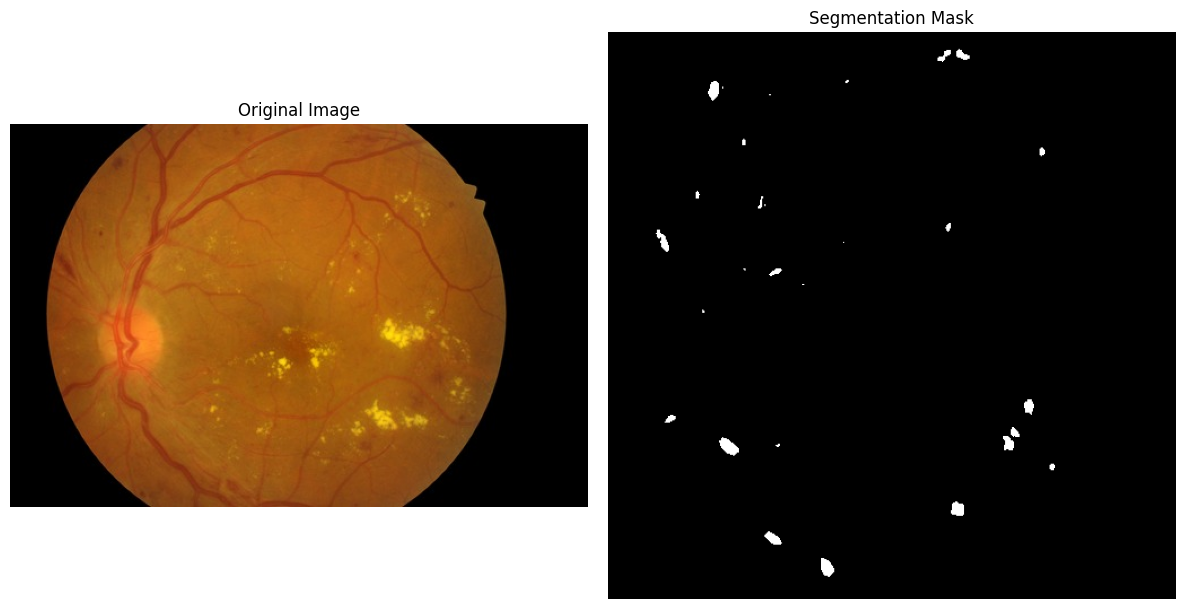

In [27]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from model import build_unet  # Assuming build_unet is your model creation function

# Function to preprocess a single image
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = image.copy()  # Keep a copy for visualization later
    
    # Preprocess image (resize, normalize, convert to tensor)
    image = cv2.resize(image, (512, 512))  # Resize to match your model input size
    image = image / 255.0  # Normalize pixel values
    image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W) format
    image = image.astype(np.float32)  # Convert to float32
    image = torch.from_numpy(image)  # Convert to tensor

    return image, original_image

# Function to visualize the segmentation mask
def visualize(original_image, mask):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Path to your single test image
image_path = "D:/jupyter/Segmentation/Original Images/Testing Set/IDRiD_79.jpg"

# Preprocess the image
image, original_image = preprocess_image(image_path)

# Load the model
model = build_unet()  # Assuming build_unet() creates an instance of your model
model.load_state_dict(torch.load("D:/jupyter/checkpoint3.pth", map_location=torch.device('cpu')))  # Load trained weights and map to CPU

# Set the model in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    inputs = image.unsqueeze(0)  # Add batch dimension
    outputs = model(inputs)  # Forward pass
    predicted_mask = torch.sigmoid(outputs).cpu().numpy()  # Sigmoid and convert to numpy array

# Assuming your model output is a single channel mask, you might threshold it for visualization
threshold = 0.5  # Adjust as needed
predicted_mask = (predicted_mask > threshold).astype(np.uint8)[0, 0, :, :] * 255  # Convert to uint8 and scale to 0-255 range

# Visualize results
visualize(original_image, predicted_mask)


In [58]:
with open('train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)

with open('valid_losses.pkl', 'wb') as f:
    pickle.dump(valid_losses, f)

with open('train_accuracies.pkl', 'wb') as f:
    pickle.dump(train_accuracies, f)

with open('valid_accuracies.pkl', 'wb') as f:
    pickle.dump(valid_accuracies, f)

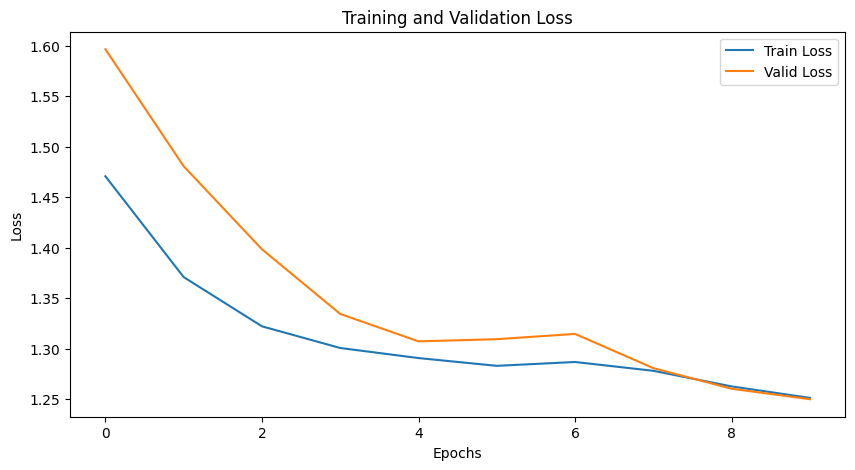

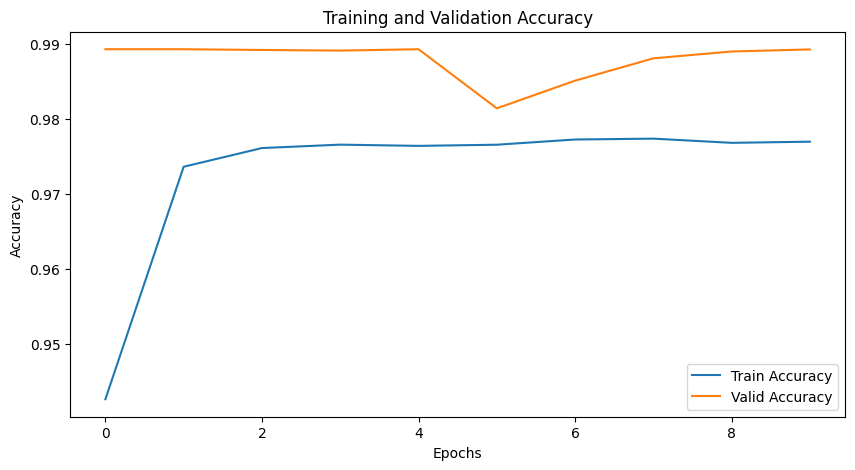

In [75]:
# Load the losses and accuracies
with open('train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)

with open('valid_losses.pkl', 'rb') as f:
    valid_losses = pickle.load(f)

with open('train_accuracies.pkl', 'rb') as f:
    train_accuracies = pickle.load(f)

with open('valid_accuracies.pkl', 'rb') as f:
    valid_accuracies = pickle.load(f)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [16]:
import torch
import pickle

# Load the checkpoint
checkpoint = torch.load('D:/jupyter/checkpoint3.pth', map_location=torch.device('cpu'))

# Aggregate state dictionaries
model_state_dict = {}
for key in checkpoint.keys():
    model_state_dict[key] = checkpoint[key]

# Assuming 'YourModelClass' is your model class definition
model = build_unet()  # Initialize your model instance
model.load_state_dict(model_state_dict)

# Save the model as a pickled file in D:\jupyter
pickle_file_path = 'D:/jupyter/model.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved as pickle file at {pickle_file_path}")


Model saved as pickle file at D:/jupyter/model.pkl


In [17]:
import torch
import pickle
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Load the pickled model
pickle_file_path = 'D:/jupyter/model.pkl'
with open(pickle_file_path, 'rb') as f:
    model = pickle.load(f)

# Assuming you have an image path
image_path = "D:/jupyter/Segmentation/Original Images/Testing Set/IDRiD_79.jpg"

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match model's expected input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Set model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(input_tensor)

# Assuming your model outputs logits or probabilities, convert them to segmentation mask
# Example: Convert softmax probabilities to predicted class labels
predicted_labels = torch.argmax(outputs, dim=1).squeeze().numpy()

# Post-process and visualize or save the results
# Example: Convert predicted_labels to an image and save it
predicted_image = Image.fromarray((predicted_labels * 255).astype(np.uint8))
predicted_image.save('predicted_segmentation.jpg')

print("Segmentation saved as predicted_segmentation.jpg")


Segmentation saved as predicted_segmentation.jpg


In [19]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from model import build_unet  # Assuming build_unet is your model creation function

# Function to preprocess a single image
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = image.copy()  # Keep a copy for visualization later
    
    # Preprocess image (resize, normalize, convert to tensor)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to match your model input size
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image = transform(image)  # Apply transformations

    return image, original_image

# Function to visualize the segmentation mask
def visualize(original_image, mask):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Path to your single test image
image_path = "D:/jupyter/Segmentation/Original Images/Testing Set/IDRiD_79.jpg"

# Preprocess the image
image, original_image = preprocess_image(image_path)

# Load the model
model = build_unet()  # Assuming build_unet() creates an instance of your model

# Directly use the model for inference
model.eval()
with torch.no_grad():
    inputs = image.unsqueeze(0)  # Add batch dimension
    outputs = model(inputs)  # Forward pass

# Assuming your model outputs logits or probabilities, convert them to segmentation mask
# Example: Convert softmax probabilities to predicted class labels
predicted_labels = torch.argmax(outputs, dim=1).squeeze().numpy()

# Visualize results
visualize(original_image, predicted_labels)


TypeError: Unexpected type <class 'numpy.ndarray'>

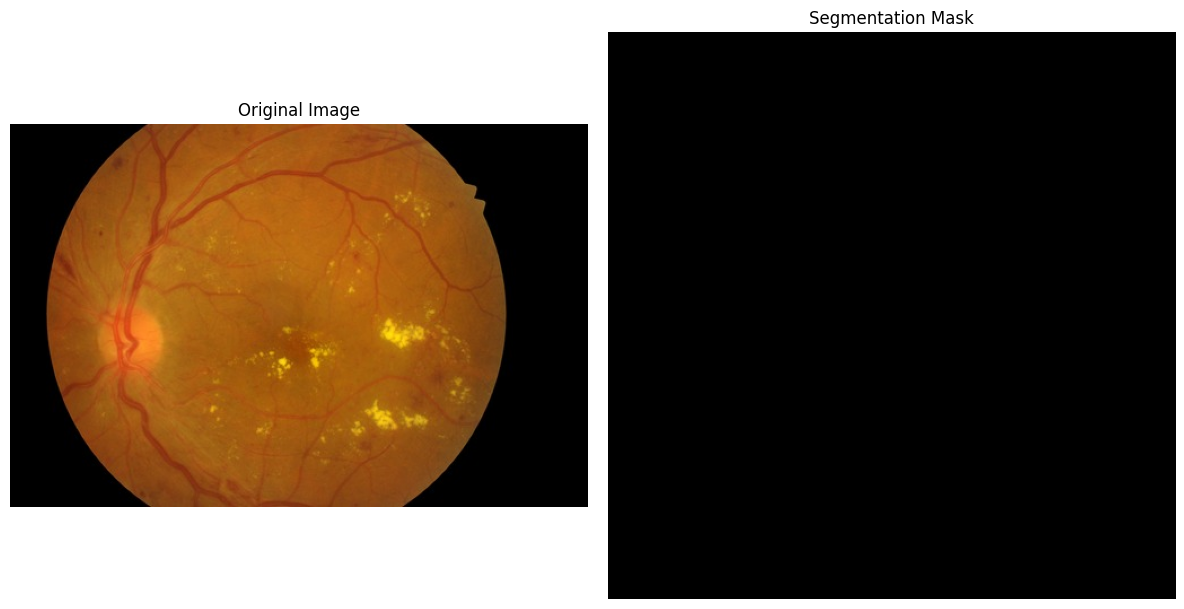

In [36]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import pickle

from model import build_unet  # Assuming build_unet is your model creation function

# Function to preprocess a single image
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = image.copy()  # Keep a copy for visualization later
    
    # Preprocess image (resize, normalize, convert to tensor)
    image = cv2.resize(image, (512, 512))  # Resize to match your model input size
    image = image / 255.0  # Normalize pixel values
    image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W) format
    image = image.astype(np.float32)  # Convert to float32
    image = torch.from_numpy(image)  # Convert to tensor

    return image, original_image

# Function to visualize the segmentation mask
def visualize(original_image, mask):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Path to your single test image
image_path = "D:/jupyter/Segmentation/Original Images/Testing Set/IDRiD_79.jpg"

# Preprocess the image
image, original_image = preprocess_image(image_path)

# Load the model from model22.pth
model_path = 'D:/jupyter/model22.pth'
model = build_unet()  # Assuming build_unet() creates an instance of your model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load trained weights and map to CPU

# Set the model in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    inputs = image.unsqueeze(0)  # Add batch dimension
    outputs = model(inputs)  # Forward pass
    predicted_mask = torch.sigmoid(outputs).cpu().numpy()  # Sigmoid and convert to numpy array

# Assuming your model output is a single channel mask, you might threshold it for visualization
threshold = 0.5  # Adjust as needed
predicted_mask = (predicted_mask > threshold).astype(np.uint8)[0, 0, :, :] * 255  # Convert to uint8 and scale to 0-255 range

# Visualize results
visualize(original_image, predicted_mask)


In [35]:
# Example of saving the model
model = build_unet()  # Assuming build_unet() creates an instance of your model
torch.save(model.state_dict(), 'D:/jupyter/model22.pth')  # Save only the state_dict
